In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import glob
from sklearn.preprocessing import StandardScaler
import json
import warnings
warnings.filterwarnings('ignore')

# Load the training Data

In [2]:
df = pd.read_csv("./train.csv")

In [3]:
df

,Station,Ob,value,measure,target,R_flag,I_flag,Z_flag,B_flag
0,AURO,1/2/2021 0:30,19.200,temp_wxt,False,2,-1,0,1
1,AURO,1/2/2021 4:30,19.800,temp_wxt,False,2,-1,0,1
2,AURO,1/2/2021 5:30,19.500,temp_wxt,False,2,-1,0,1
3,AURO,1/2/2021 7:30,18.500,temp_wxt,False,2,-1,0,1
4,AURO,2/16/2021 2:30,17.700,temp_wxt,False,2,-1,0,1
...,...,...,...,...,...,...,...,...,...
6593269,WINE,4/3/2021 6:26,-5.289,blackglobetemp,False,4,-1,-1,-1
6593270,WINE,4/3/2021 6:27,-5.189,blackglobetemp,False,4,-1,-1,-1
6593271,WINE,4/3/2021 6:28,-5.123,blackglobetemp,False,4,-1,-1,-1
6593272,WINE,4/3/2021 6:29,-5.090,blackglobetemp,False,4,-1,-1,-1




## Look at count for Stations in training data

<AxesSubplot:xlabel='Station'>

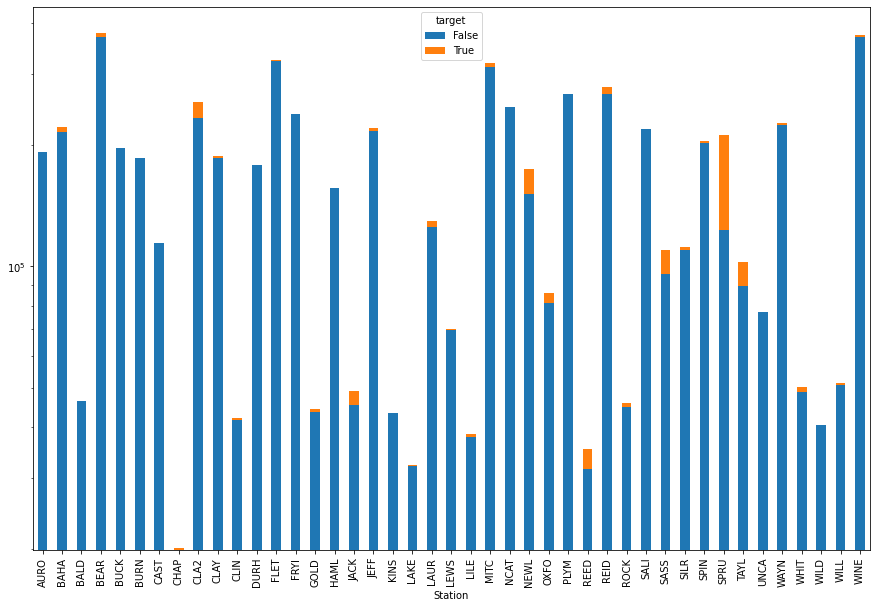

In [4]:

# df[['Station', 'target']].value_counts().plot(kind='bar', figsize=(10,6), stacked=True)
df.groupby(['Station', 'target']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)

## Look at count for Target values
### This is the value we want to predict

<AxesSubplot:>

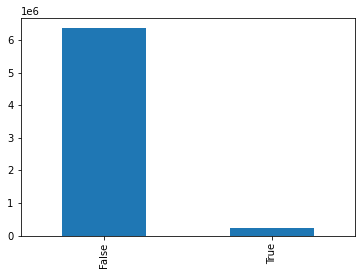

In [34]:
df['target'].value_counts().plot(kind='bar')

## Look at count for each Flag values by the Station

```
QC Check	Flag Type	Flag Score	Description

Range	R	R0	Passes at highest level
		R1	Probably Good.
		R2	Maybe Good. Possible Extreme Event
		R3	Doubtful it is good. Could be an isolated case.
		R4	Fails at highest level
			
Buddy	B	B0	Passes at Highest level
		B1	Probably Good.
		B2	Maybe Good. Possible Extreme Event.
		B3	Probably Bad.
		B4	Doubtful it is good.
		B5	Fails at Highest Level
			
Intersensor	I	I0	Passes at Highest level
		I1	Probably Good. 
		I2	Probably Bad or can't determine.
		I4	Fails at Highest level
			
Trend	Z	Z0	Passes at Highest Level
		Z2	Can't determine if value is good or bad.
		Z4	Fails at Highest Level
			
User	U	U0	Data point passed by scientist
		U4	Data point failed by scientist
        

QC Scores	Score	Description
	-1	Data has not been QC'd
	0	Data is considered good.
	1	Data is probably good.
	2	Data is probably bad.
	3	Data is considered bad.

```


<AxesSubplot:xlabel='Station'>

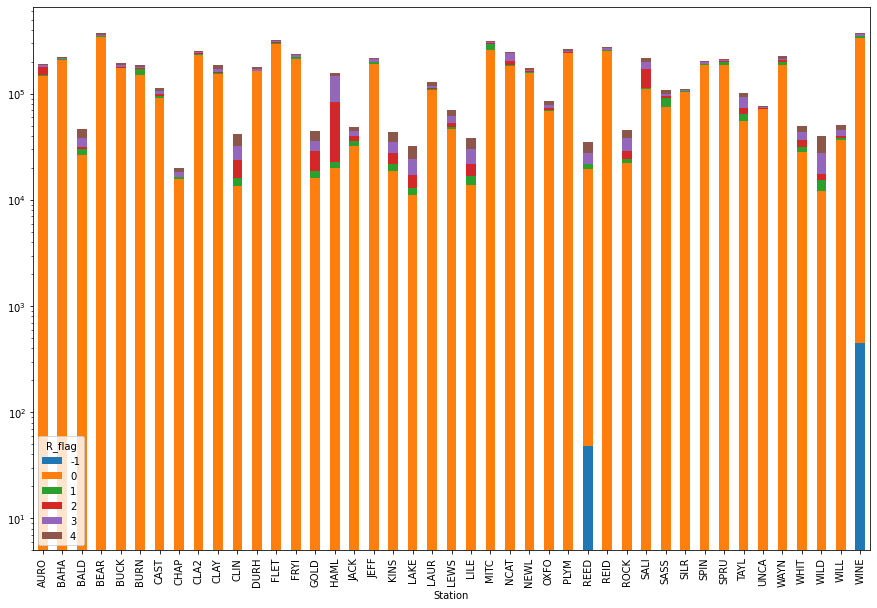

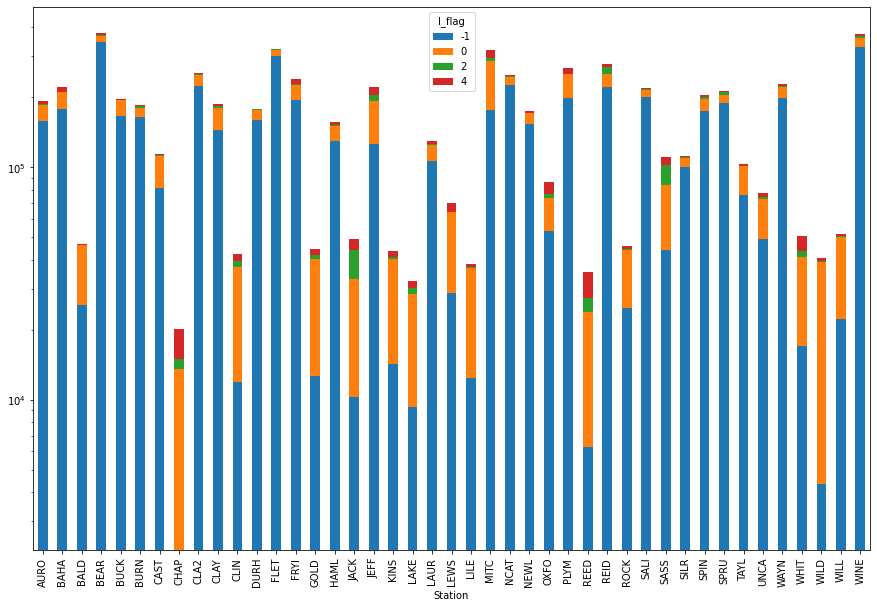

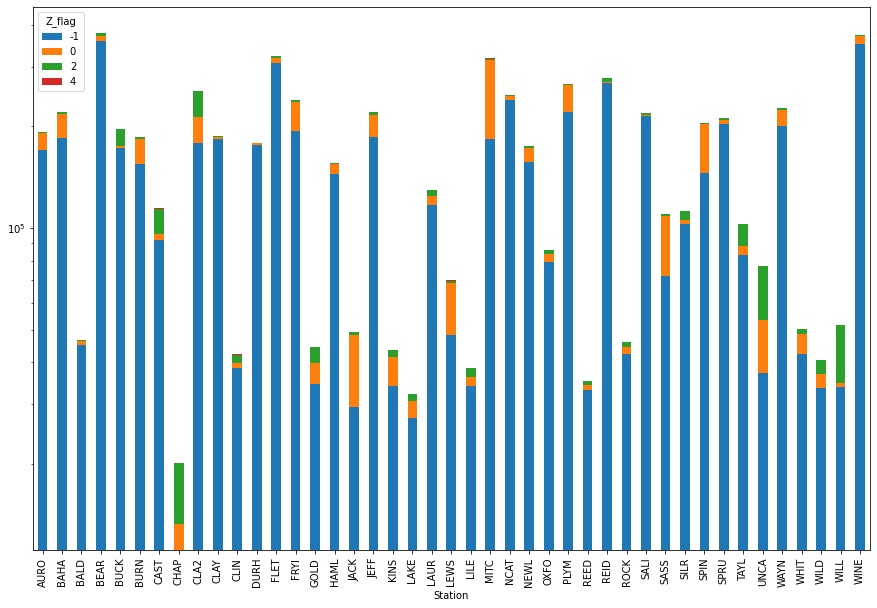

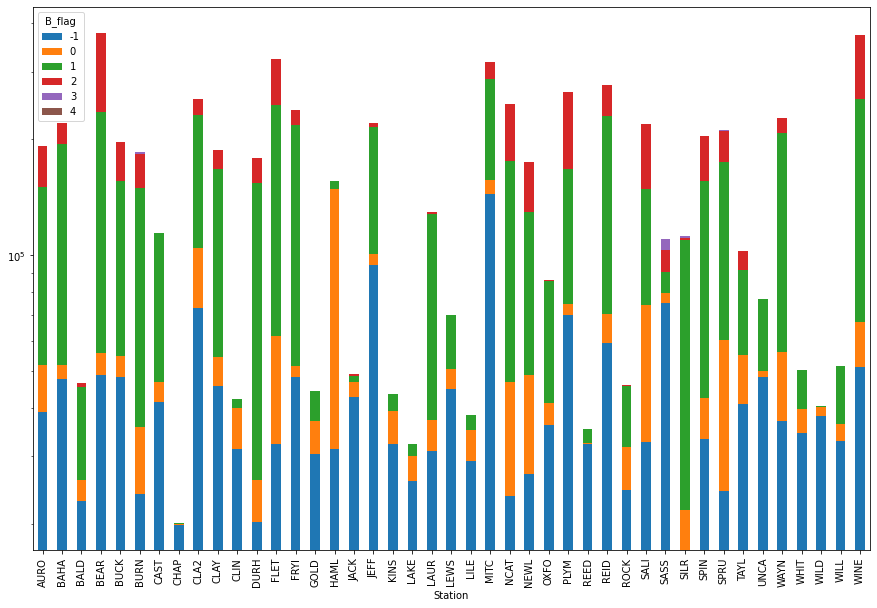

In [35]:
df.groupby(['Station', 'R_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
df.groupby(['Station', 'I_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
df.groupby(['Station', 'Z_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
df.groupby(['Station', 'B_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)


# Look at only Target = True data

In [5]:
dtrue = df[df['target'] == True]
dfalse = df[df['target'] == False]

<AxesSubplot:>

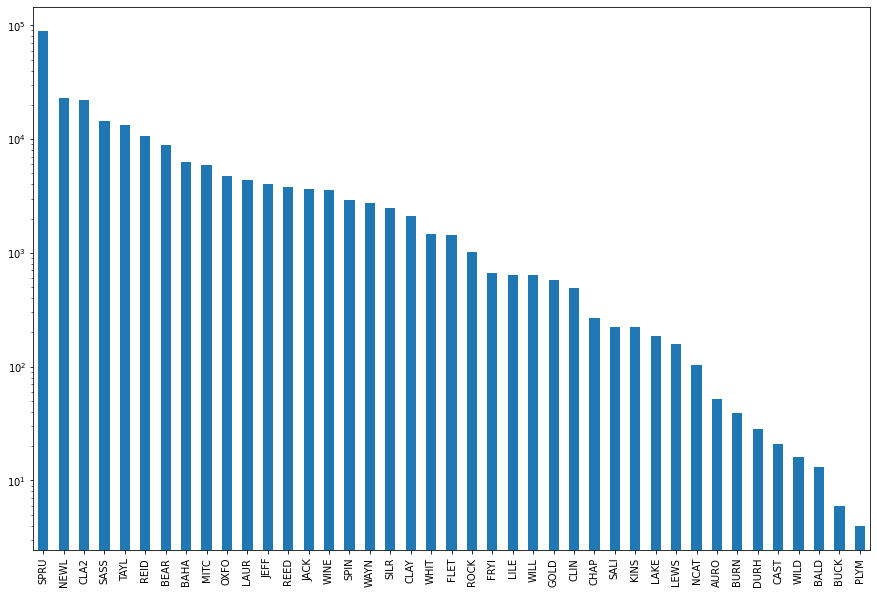

In [6]:
dtrue['Station'].value_counts().plot(kind='bar', figsize=(15,10), logy= True)

<AxesSubplot:xlabel='Station'>

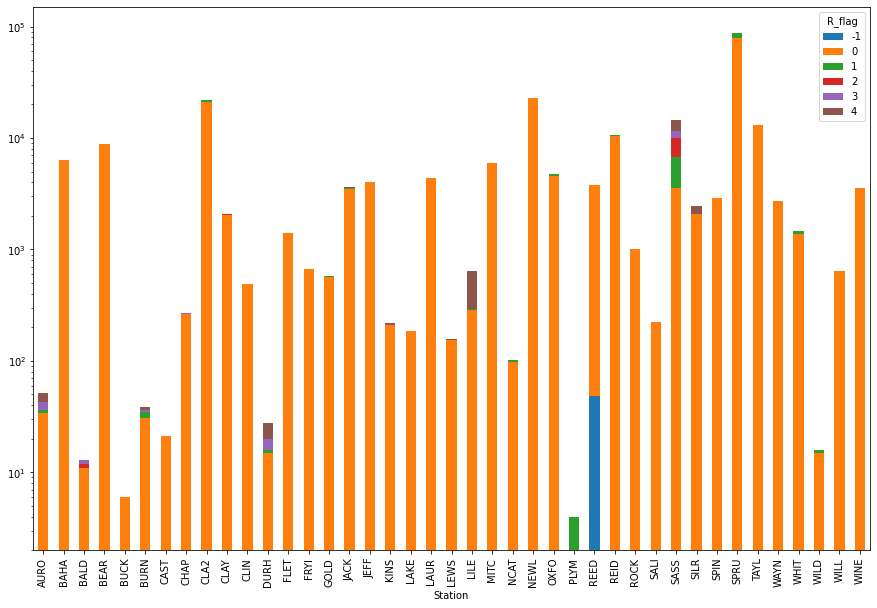

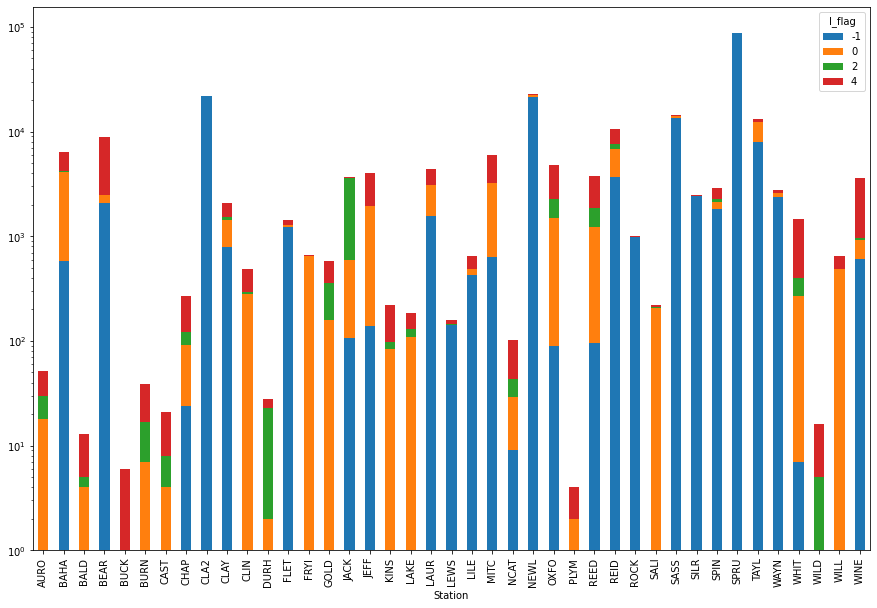

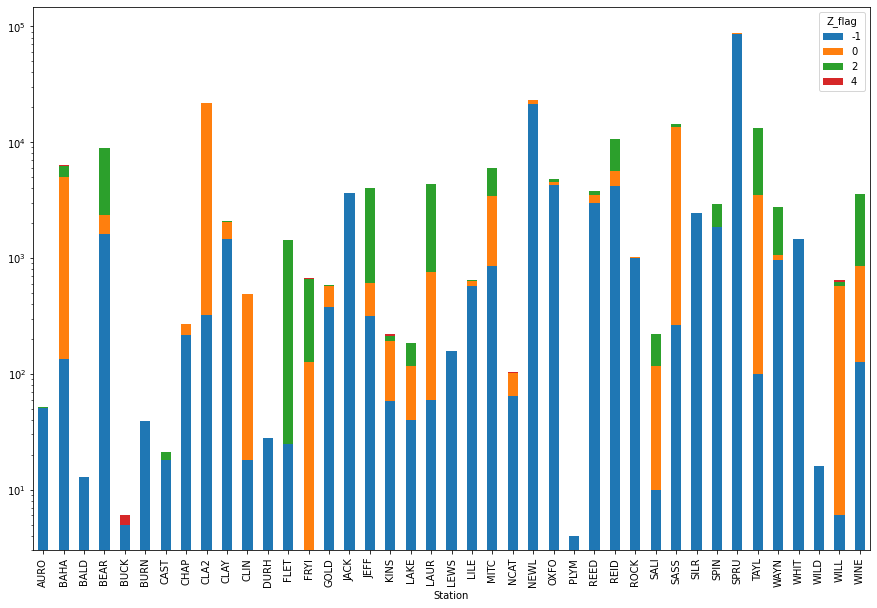

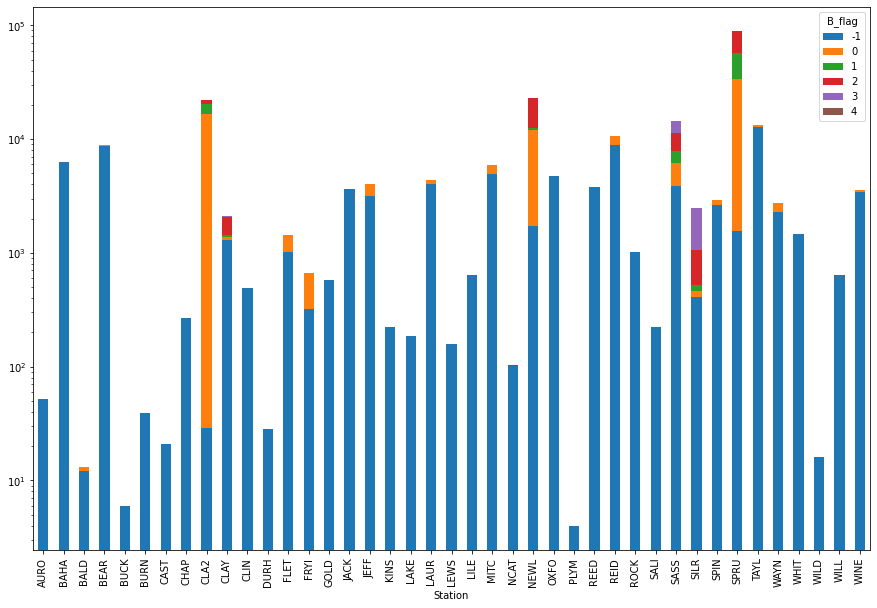

In [7]:
dtrue.groupby(['Station', 'R_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
dtrue.groupby(['Station', 'I_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
dtrue.groupby(['Station', 'Z_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)
dtrue.groupby(['Station', 'B_flag']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)

### Look at which measure each station is considering when it is marked True

This data tells us what each station is marking which measurement as the reason for the data being erronous 

<AxesSubplot:xlabel='Station'>

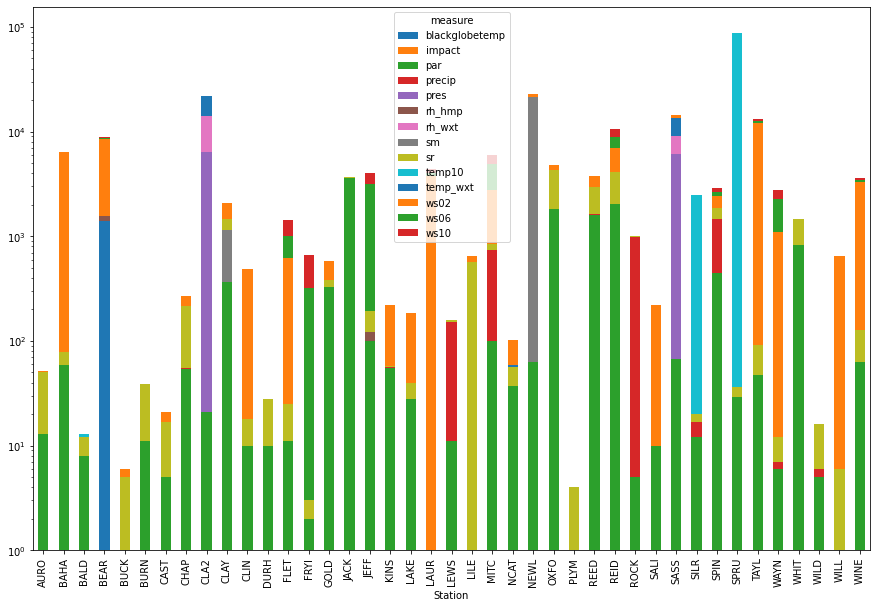

In [8]:
dtrue.groupby(['Station', 'measure']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,10), logy= True)

# To fully understand and utilize the dataset, we have to merge it with the full data that is supplied for each Station at a given data/timme.

#### We have already done this and is saved as full.csv

In [11]:
dfull = pd.read_csv("./full.csv")

In [12]:
dfull.columns

Index(['Station_x', 'Ob', 'value', 'measure', 'target', 'R_flag', 'I_flag',
       'Z_flag', 'B_flag', 'Unnamed: 0', 'Station_y', 'temp_wxt', 'temp_hmp',
       'rh_wxt', 'rh_hmp', 'ws10', 'wd10', 'gust10', 'precip', 'impact',
       'pres', 'par', 'sr', 'st', 'sm', 'temp10', 'ws02', 'wd02', 'gust02',
       'ws06', 'wd06', 'gust06', 'leafwetness', 'blackglobetemp'],
      dtype='object')

# The full data should also be looked at to see how each datapoint is being used.

### But the data is really big, so we will only look at the first few days to see the general trends for each measurement through a day.

In [11]:
path = os.getcwd()
csv_files = glob.glob(os.path.join(path, "full/*.csv"))

each_Station = {}

# load each station data, standardize it and get 5 PC for them, join into the data.

just_1 = csv_files[0:2]   # just replace with csv_files in the loop for all files.
for f in just_1:
     
    # read the csv file
    each_Station[f[101:105].lower()] = pd.read_csv(f)


In [15]:
each_Station['auro']
auro = each_Station['auro'][each_Station['auro'].columns[3:26]]

# standardize the dataset
# auro = pd.DataFrame(StandardScaler().fit_transform(auro),columns = auro.columns).fillna(0)

# put the date time back in
auro['Ob'] = each_Station['auro']['Ob']

In [16]:
# look at the top 3000 data points
auro = auro.head(20000)
auro

,temp_wxt,temp_hmp,rh_wxt,rh_hmp,ws10,wd10,gust10,precip,impact,pres,...,temp10,ws02,wd02,gust02,ws06,wd06,gust06,leafwetness,blackglobetemp,Ob
0,11.4,11.150,90.3,100.0,2.066,18.13,2.999,0.0,0.0,1024.1,...,11.250,2.2,330.0,3.0,1.537,358.5,2.430,432.5,11.340,2021-01-01 00:00:00
1,11.5,11.110,90.3,100.0,0.900,293.70,2.234,0.0,0.0,1024.1,...,11.230,1.2,266.0,1.4,0.941,303.2,2.176,414.2,11.310,2021-01-01 00:01:00
2,11.5,11.110,90.4,99.9,0.627,68.62,1.352,0.0,0.0,1024.1,...,11.220,0.8,312.0,1.2,0.552,326.4,1.039,420.3,11.270,2021-01-01 00:02:00
3,11.5,11.010,90.4,100.0,0.564,26.12,1.313,0.0,0.0,1024.1,...,11.220,1.5,273.0,2.0,1.040,281.1,1.470,421.7,11.290,2021-01-01 00:03:00
4,11.4,11.160,90.4,100.0,0.771,20.86,1.999,0.0,0.0,1024.1,...,11.230,1.8,88.0,2.0,1.171,93.8,1.921,432.5,11.250,2021-01-01 00:04:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5.0,5.019,90.0,99.7,0.578,231.40,1.215,0.0,0.0,1010.9,...,5.776,0.2,259.0,0.4,0.497,235.4,0.784,573.8,3.478,2021-01-14 21:16:00
19996,5.1,4.877,90.0,99.6,0.890,210.90,1.117,0.0,0.0,1011.0,...,5.787,0.5,267.0,0.5,0.554,213.3,0.784,574.4,3.526,2021-01-14 21:17:00
19997,5.0,4.830,90.0,99.5,0.719,208.50,1.019,0.0,0.0,1011.0,...,5.743,0.5,274.0,0.5,0.670,219.5,1.039,575.1,3.502,2021-01-14 21:18:00
19998,5.0,4.877,90.0,99.5,0.287,243.40,0.529,0.0,0.0,1011.0,...,5.655,0.5,254.0,0.6,0.178,250.3,0.294,575.4,3.502,2021-01-14 21:19:00


# Most of the Datapoints look flat or Cyclic by the data/night cycle.

<AxesSubplot:xlabel='Ob'>

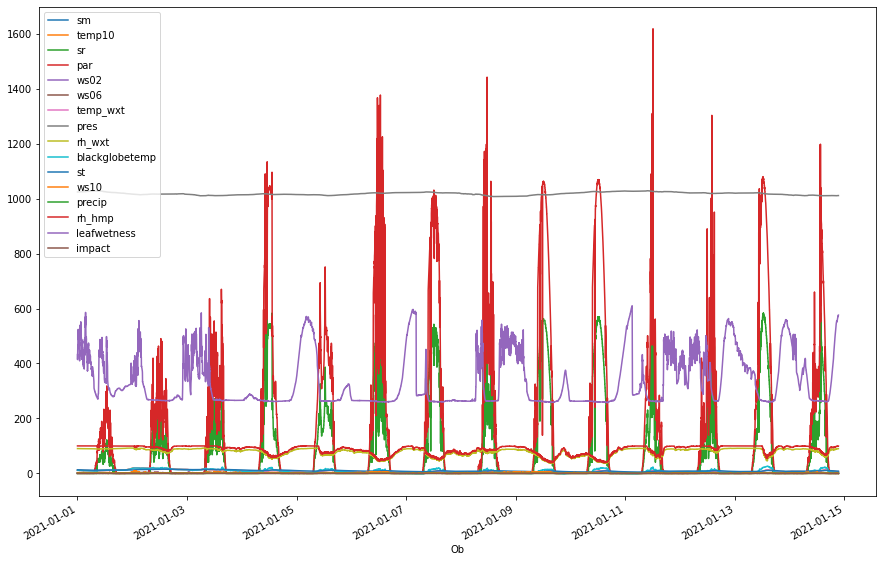

In [17]:
dict(df['measure'].value_counts())
all_true_measurements = list(dict(df['measure'].value_counts()).keys())
all_true_measurements.append('Ob')
auro[all_true_measurements].plot(x='Ob', figsize=(15,10))

<AxesSubplot:xlabel='Ob'>

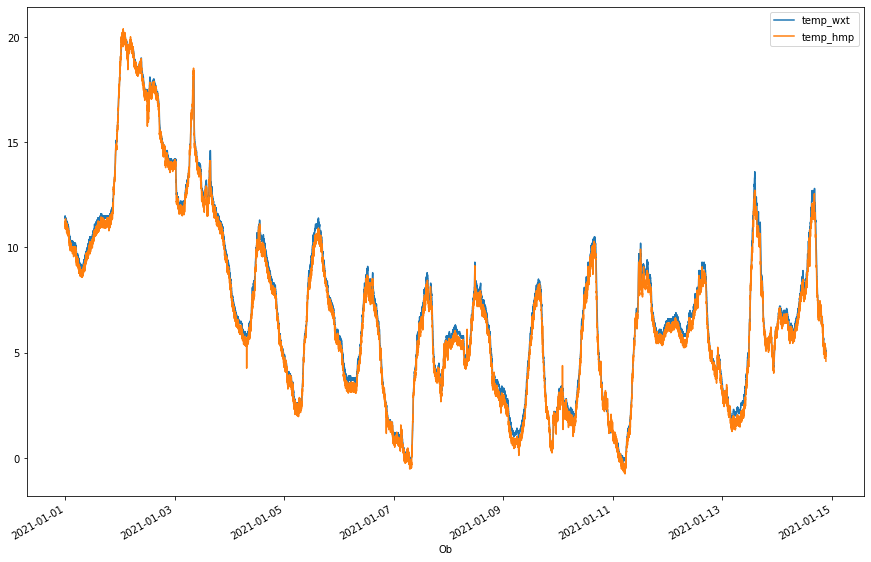

In [24]:
auro[['Ob', 'temp_wxt', 'temp_hmp']].plot(x='Ob', figsize=(15,10), )

<AxesSubplot:xlabel='Ob'>

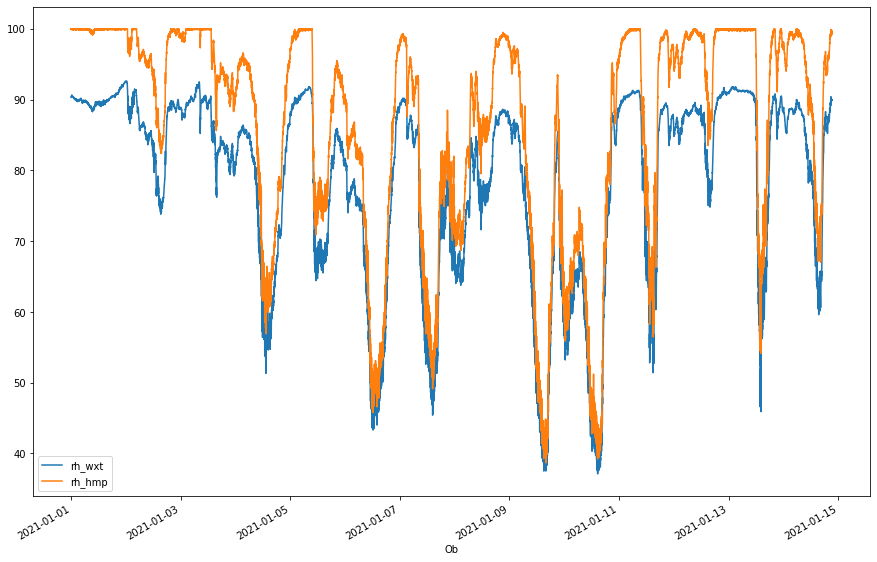

In [23]:
auro[['Ob', 'rh_wxt', 'rh_hmp']].plot(x='Ob', figsize=(15,10), )

<AxesSubplot:xlabel='Ob'>

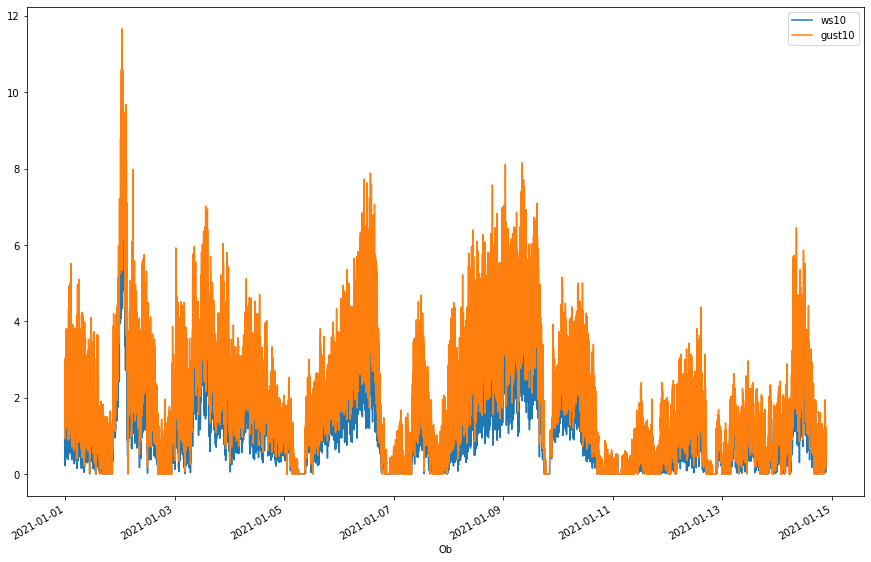

In [30]:
auro[['Ob', 'ws10', 'gust10']].plot(x='Ob', figsize=(15,10), )